# Spatial Processing Benchmarks in Python
### Krzysztof Dyba

In [1]:
# display multiple outputs from single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# required libraries
# import os, zipfile, timeit, random, statistics, urllib.request
# import rasterio, rasterio.plot

## Introduction

The primary way to perform a benchmark in Python is to use the `Timer` class from `{timeit}` library.
You can view the documentation interactively in Jupyter Notebook by using the question mark "?" before the function or by using the dedicated `help()` function.
However, first we need to import the library.

In [3]:
import timeit
?timeit.Timer

The use of this function is a bit more complicated than in R.
Let's test it as before with the example of sampling numbers with replacement.
For this purpose, we can use `choices()` function from the `{random}` library.

In [4]:
import random
random.choices(range(1, 100), k = 5)

[9, 65, 97, 3, 21]

Now we will use the `repeat()` function which performs the benchmark multiple times.
We need to define:
  1. expression as text
  2. global namespace
  3. number of executions of the expression
  4. number of repetitions of the test
The result will be a list with timings.

In [5]:
n = 1_000_000
t = timeit.repeat("random.choices(range(1, 100), k = n)",
                  globals = globals(), number = 1, repeat = 5)
t

[0.4387889070000002,
 0.35118532000000036,
 0.3565279430000001,
 0.349307971,
 0.3539838959999999]

From these values, we can calculate the basic statistics (like mean and standard deviation).
Statistical functions can be found in the `{statistics}` library.

In [6]:
import statistics
round(statistics.mean(t), 2)
round(statistics.stdev(t), 4)

0.37

0.0386

For Jupyter Notebooks, there is an alternative easier way.
We can use the `timeit()` function with a percent symbol:
  - `%timeit` to benchmark a single function
  - `%%timeit` to benchmark an entire cell

In [7]:
%timeit -r 5 -n 1 random.choices(range(1, 100), k = n)

359 ms ± 7.79 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [8]:
%%timeit -r 5 -n 1
random.choices(range(1, 100), k = n)

374 ms ± 15.4 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


**Exercise**

Compare computing the mean value of the list using `statistics.mean()` and `sum() / len()` functions.

## Part I: Raster Data



### Data Source

For testing, we will use exactly the same raster as in the previous part.
For more information, see the [R notebook](https://kadyb.github.io/OGH2022/R.html#Data_Source).

In [9]:
import os
import zipfile
import urllib.request

url = "https://srtm.csi.cgiar.org/wp-content/uploads/files/srtm_5x5/TIFF/srtm_39_02.zip"

if not os.path.isdir("data"):
    os.mkdir("data")
    urllib.request.urlretrieve(url, "data/srtm.zip")
    with zipfile.ZipFile("data/srtm.zip","r") as zip_ref:
        zip_ref.extractall("data") # ~70 MB tif

### Benchmarks

In [10]:
import rasterio

#### Data Loading

From a user perspective, Python requires more programming skills.
Consequently, you will have to write more lines of code and the workflow will eventually be more complex.
Loading data in `{rasterio}` consists of several steps:
  1. Open a connection to a file.
  2. Load metadata (e.g. resolution, coordinate system).
  3. Load values into Python array.
  4. Close the connection to the file.
Our raster consists of one band, but if it consisted of many you would have to iterate over all the bands to load them.

In [11]:
# open connection to file
raster = rasterio.open("data/srtm_39_02.tif")

# load some metadata
extent = raster.bounds
crs = raster.crs
res = raster.res
nlyr = raster.count
shape = raster.shape
transform = raster.transform

# load values
# if there are NAs in raster, then use the `masked = True` argument
matrix = raster.read(masked = True)

# close connection
raster.close()

Let's print the metadata.

In [12]:
print(extent)
print(crs)
print(res)
print(nlyr)
print(shape)

BoundingBox(left=10.0, bottom=50.0, right=15.0, top=55.0)
EPSG:4326
(0.0008333333333333334, 0.0008333333333333334)
1
(6000, 6000)


Let's also print the small part of matrix.
Note that indexing in Python starts at 0!

In [13]:
matrix[0, 0:3, 0:3] # check another extent yourself

masked_array(
  data=[[--, --, --],
        [--, --, --],
        [--, --, --]],
  mask=[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],
  fill_value=-32768,
  dtype=int16)

Missing values (NA) are marked with the value -32768, and the datatype is int16.
We can also check how much space this object takes up in memory using `.nbytes` method.

In [14]:
# return result in MB
matrix.nbytes / 1024**2

68.66455078125

As you can see, the structure of raster data in `{rasterio}` looks quite different than in R.
After the data is loaded, we can visualize it.
The easiest way to do this is to use the `show()` function from the `plot` module.
By default, the matrix coordinates are stored in the row/column system.
To convert them to geographic coordinates you need to use the affine transformation parameters previously stored in the `transform` variable.

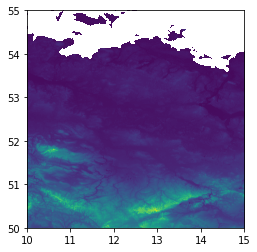

<AxesSubplot:>

In [15]:
from rasterio.plot import show
show(matrix, transform = transform)

Now let's perform the benchmark.

In [16]:
%%timeit -r 5 -n 1
raster = rasterio.open("data/srtm_39_02.tif")
matrix = raster.read(masked = True)
raster.close()

322 ms ± 8.43 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


#### Cropping

In [17]:
# minx, miny, maxx, maxy
# ext = box(11, 14, 51, 53)